In [20]:
import os

import altair as alt

import numpy as np
from sklearn.decomposition import PCA
import pandas as pd

import matplotlib
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt


from utils import load_hidden_representations_from_hdf5, read_templates_from_file

----

In [21]:
# params
log_dir = "/logfiles"
model = "bigscience-T0_3B"
module = "encoder"
task = "rte"

In [22]:
# assertions
assert model == "bigscience-T0_3B"
assert module == "encoder"
assert task == "rte"

## Prompts

In [23]:
df = read_templates_from_file(f"/t0-analysis/prompts/{task}/all.csv")
# df = read_templates_from_file(f"/t0-analysis/prompts/{task}/fixed_prompt.csv")
# df = read_templates_from_file(f"/t0-analysis/prompts/{task}/fixed_target_yes_no.csv")
display(df)

,name,template,category,includes_targets,targets,target_ids,shuffle
0,gpt_3_yes_no_with_targets,{premise} Question: {hypothesis} Yes or No?,instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
1,mnli_crowdsource_with_targets,"{premise} Using only the above description and what you know about the world, is ""{hypothesis}"" definitely correct? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
2,based_on_previous_passage_with_targets,"{premise} Based on the previous passage, is it true that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
3,infer_with_targets,"Suppose {premise} Can we infer that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
4,follow_with_targets,Given that {premise} Does it follow that {hypothesis} Yes or No?,instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
5,imply_with_targets,"{premise} Question: Does this imply that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
6,guaranteed_with_targets,"Given {premise} Is it guaranteed true that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
7,justified_with_targets,"{premise} Are we justified in saying that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
8,must_be_true_with_targets,"Given that {premise} Therefore, it must be true that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
9,should_assume_with_targets,"Given {premise} Should we assume that ""{hypothesis}"" is true? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False


In [24]:
# load prompted inputs and labels
df_inputs = {}
for _, row in df.iterrows():
    prompt = row['name']
    df_inputs[prompt] = pd.read_csv(f"/logfiles/{task}/{model}/{module}/{prompt}/prompted_samples.csv", sep='\t', index_col=0)


In [25]:
# load decoded predictions
df_outputs = {}
for _, row in df.iterrows():
    prompt = row['name']
    df_outputs[prompt] = pd.read_csv(f"/logfiles/{task}/{model}/{module}/{prompt}/decoded_predictions.csv", sep='\t', names=['predicitons'])

## PCA

In [26]:
def unison_shuffled_copies(a, b):
    # from: https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [27]:
use_pattern = [
    "gpt_3_yes_no_with_targets",
    # "mnli_crowdsource_with_targets",
    # "based_on_previous_passage_with_targets",
    # "infer_with_targets",
    # "follow_with_targets",
    # "imply_with_targets",
    # "guaranteed_with_targets",
    # "justified_with_targets",
    "must_be_true_with_targets",
    # "should_assume_with_targets",
    # "gpt_3_true_false_with_targets",
    # "gpt_3_cat_dog_with_targets",
    # "gpt_3_cat_dog_with_targets_yes_no",
    # "gpt_3_yes_no_without_targets",
    # "words_appear_with_targets",
    # "similar_words_with_targets",
    # "start_with_the_with_targets",
    # "same_meaning_with_targets",
    # "paraphrase_with_targets",
    # "paraphrase_r_with_targets",
    # "summarize_with_targets",
    # "inflection_with_targets",
    # "null_pattern_with_targets",
    # "null_pattern_r_with_targets",
    # "null_pattern_without_targets",
    # "null_pattern_r_without_targets",
    "premise_only_with_targets",
    # "premise_only_without_targets",
    "hypothesis_only_with_targets",
    # "hypothesis_only_without_targets",
]

In [28]:
# for layer in range(0, 10):
for layer in range(0, 25):
# for layer in range(24, 25):
    print('layer=', layer)
    file_names, prompt_names = [], []

    for _, row in df.iterrows():
        if row['name'] in use_pattern:
            file_names.append(f"{task}/{model}/{module}/{row['name']}/hidden_represenations_layer{layer}_avg.hdf5",)
            prompt_names.append(row['name'])


    # load hidden representations from hdf5 file
    representations = None
    classes = []
    n_sequences = 0

    for idx, file_name in enumerate(file_names):
        hidden_representations = load_hidden_representations_from_hdf5(os.path.join(log_dir, file_name))
        # print(hidden_representations.shape)
        n_sequences = hidden_representations.shape[0]

        if representations is None:
            representations = hidden_representations
        else:
            representations = np.concatenate((representations, hidden_representations), axis=0)

        classes += n_sequences * [idx] # assign representations to classes
    
    classes = np.asarray(classes)

    # shuffle representations and classes
    X, y = unison_shuffled_copies(representations, classes)
    print(X.shape, y.shape)

    # perform PCA on hidden representations
    print('PCA for prompts:', prompt_names)

    for n_components in range(1, 3):
        pca = PCA(n_components=n_components)
        pca.fit(X)

        # variance explained by each of the principal components
        print(f"model:{model}; module:{module}; layer:{layer}; n_components: {n_components}; variance explained: {pca.explained_variance_ratio_}")
        print(np.sum(pca.explained_variance_ratio_))
    print('\n')


layer= 0


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5503.03it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
model:bigscience-T0_3B; module:encoder; layer:0; n_components: 1; variance explained: [0.94238603]
0.94238603
model:bigscience-T0_3B; module:encoder; layer:0; n_components: 2; variance explained: [0.9423862  0.00344276]
0.945829


layer= 1


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5659.17it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
model:bigscience-T0_3B; module:encoder; layer:1; n_components: 1; variance explained: [0.41632432]
0.41632432
model:bigscience-T0_3B; module:encoder; layer:1; n_components: 2; variance explained: [0.41632432 0.12569502]
0.54201937


layer= 2


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5584.56it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
model:bigscience-T0_3B; module:encoder; layer:2; n_components: 1; variance explained: [0.97988504]
0.97988504
model:bigscience-T0_3B; module:encoder; layer:2; n_components: 2; variance explained: [0.97988504 0.00987061]
0.98975563


layer= 3


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5681.78it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
model:bigscience-T0_3B; module:encoder; layer:3; n_components: 1; variance explained: [0.9791009]
0.9791009
model:bigscience-T0_3B; module:encoder; layer:3; n_components: 2; variance explained: [0.9791009  0.00878859]
0.98788947


layer= 4


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5739.49it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
model:bigscience-T0_3B; module:encoder; layer:4; n_components: 1; variance explained: [0.9786893]
0.9786893
model:bigscience-T0_3B; module:encoder; layer:4; n_components: 2; variance explained: [0.9786893  0.00877031]
0.9874596


layer= 5


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5555.71it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
model:bigscience-T0_3B; module:encoder; layer:5; n_components: 1; variance explained: [0.97815436]
0.97815436
model:bigscience-T0_3B; module:encoder; layer:5; n_components: 2; variance explained: [0.97815436 0.00891219]
0.98706657


layer= 6


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5405.33it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
model:bigscience-T0_3B; module:encoder; layer:6; n_components: 1; variance explained: [0.99873316]
0.99873316
model:bigscience-T0_3B; module:encoder; layer:6; n_components: 2; variance explained: [9.987333e-01 6.314268e-04]
0.99936473


layer= 7


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 4615.13it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
model:bigscience-T0_3B; module:encoder; layer:7; n_components: 1; variance explained: [0.9985578]
0.9985578
model:bigscience-T0_3B; module:encoder; layer:7; n_components: 2; variance explained: [9.9855781e-01 6.8728026e-04]
0.9992451


layer= 8


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 4570.11it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
model:bigscience-T0_3B; module:encoder; layer:8; n_components: 1; variance explained: [0.9983577]
0.9983577
model:bigscience-T0_3B; module:encoder; layer:8; n_components: 2; variance explained: [9.983575e-01 7.381611e-04]
0.9990956


layer= 9


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 4646.51it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
model:bigscience-T0_3B; module:encoder; layer:9; n_components: 1; variance explained: [0.99806786]
0.99806786
model:bigscience-T0_3B; module:encoder; layer:9; n_components: 2; variance explained: [9.9806786e-01 7.8655005e-04]
0.9988544


layer= 10


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 4550.22it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
model:bigscience-T0_3B; module:encoder; layer:10; n_components: 1; variance explained: [0.99771416]
0.99771416
model:bigscience-T0_3B; module:encoder; layer:10; n_components: 2; variance explained: [9.9771416e-01 8.1630051e-04]
0.99853045


layer= 11


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5201.43it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
model:bigscience-T0_3B; module:encoder; layer:11; n_components: 1; variance explained: [0.9972034]
0.9972034
model:bigscience-T0_3B; module:encoder; layer:11; n_components: 2; variance explained: [9.9720341e-01 8.4174733e-04]
0.99804515


layer= 12


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5577.13it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
model:bigscience-T0_3B; module:encoder; layer:12; n_components: 1; variance explained: [0.9961708]
0.9961708
model:bigscience-T0_3B; module:encoder; layer:12; n_components: 2; variance explained: [0.9961708  0.00118775]
0.99735856


layer= 13


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5681.31it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
model:bigscience-T0_3B; module:encoder; layer:13; n_components: 1; variance explained: [0.9944514]
0.9944514
model:bigscience-T0_3B; module:encoder; layer:13; n_components: 2; variance explained: [0.9944514  0.00159955]
0.99605095


layer= 14


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5047.12it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
model:bigscience-T0_3B; module:encoder; layer:14; n_components: 1; variance explained: [0.9926913]
0.9926913
model:bigscience-T0_3B; module:encoder; layer:14; n_components: 2; variance explained: [0.9926913  0.00200411]
0.99469537


layer= 15


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5713.69it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
model:bigscience-T0_3B; module:encoder; layer:15; n_components: 1; variance explained: [0.99091774]
0.99091774
model:bigscience-T0_3B; module:encoder; layer:15; n_components: 2; variance explained: [0.99091774 0.00191949]
0.99283725


layer= 16


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 4524.19it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
model:bigscience-T0_3B; module:encoder; layer:16; n_components: 1; variance explained: [0.9872769]
0.9872769
model:bigscience-T0_3B; module:encoder; layer:16; n_components: 2; variance explained: [0.9872769  0.00228656]
0.98956347


layer= 17


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5767.36it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
model:bigscience-T0_3B; module:encoder; layer:17; n_components: 1; variance explained: [0.9812429]
0.9812429
model:bigscience-T0_3B; module:encoder; layer:17; n_components: 2; variance explained: [0.98124266 0.00320482]
0.9844475


layer= 18


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5522.68it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
model:bigscience-T0_3B; module:encoder; layer:18; n_components: 1; variance explained: [0.97119695]
0.97119695
model:bigscience-T0_3B; module:encoder; layer:18; n_components: 2; variance explained: [0.9711972  0.00672717]
0.97792435


layer= 19


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5738.27it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
model:bigscience-T0_3B; module:encoder; layer:19; n_components: 1; variance explained: [0.9623095]
0.9623095
model:bigscience-T0_3B; module:encoder; layer:19; n_components: 2; variance explained: [0.9623095  0.00766877]
0.9699783


layer= 20


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5858.82it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
model:bigscience-T0_3B; module:encoder; layer:20; n_components: 1; variance explained: [0.947841]
0.947841
model:bigscience-T0_3B; module:encoder; layer:20; n_components: 2; variance explained: [0.947841   0.01126741]
0.9591084


layer= 21


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5796.39it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
model:bigscience-T0_3B; module:encoder; layer:21; n_components: 1; variance explained: [0.9329102]
0.9329102
model:bigscience-T0_3B; module:encoder; layer:21; n_components: 2; variance explained: [0.9329102  0.01364922]
0.9465594


layer= 22


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 4468.41it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
model:bigscience-T0_3B; module:encoder; layer:22; n_components: 1; variance explained: [0.90946615]
0.90946615
model:bigscience-T0_3B; module:encoder; layer:22; n_components: 2; variance explained: [0.90946615 0.01510908]
0.9245752


layer= 23


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5574.72it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
model:bigscience-T0_3B; module:encoder; layer:23; n_components: 1; variance explained: [0.86951923]
0.86951923
model:bigscience-T0_3B; module:encoder; layer:23; n_components: 2; variance explained: [0.86951923 0.02374044]
0.89325964


layer= 24


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5411.07it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
model:bigscience-T0_3B; module:encoder; layer:24; n_components: 1; variance explained: [0.14011869]
0.14011869
model:bigscience-T0_3B; module:encoder; layer:24; n_components: 2; variance explained: [0.14011864 0.06567797]
0.20579661




## Visualize PCA

layer= 0


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5116.22it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
(1108, 2)
model:bigscience-T0_3B; module:encoder; layer:0; n_components: 2; variance explained: [0.9423862  0.00344276]
0.945829


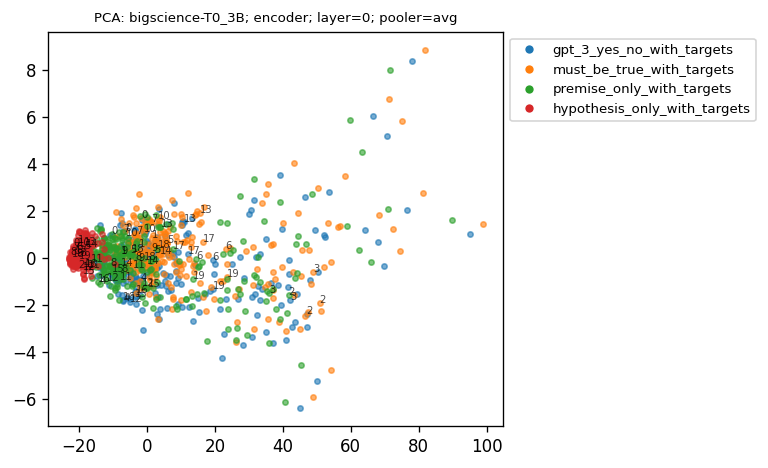



layer= 1


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5527.20it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
(1108, 2)
model:bigscience-T0_3B; module:encoder; layer:1; n_components: 2; variance explained: [0.41632432 0.12569511]
0.5420194


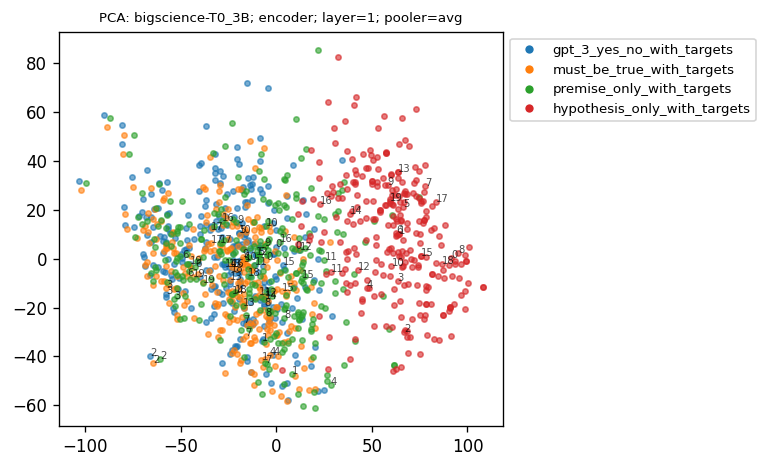



layer= 2


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5310.19it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
(1108, 2)
model:bigscience-T0_3B; module:encoder; layer:2; n_components: 2; variance explained: [0.97988546 0.00987061]
0.98975605


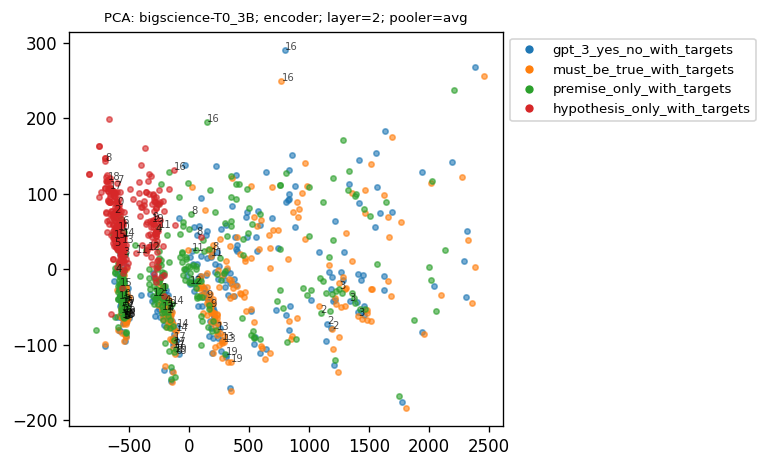



layer= 3


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5738.41it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
(1108, 2)
model:bigscience-T0_3B; module:encoder; layer:3; n_components: 2; variance explained: [0.97910106 0.0087886 ]
0.98788965


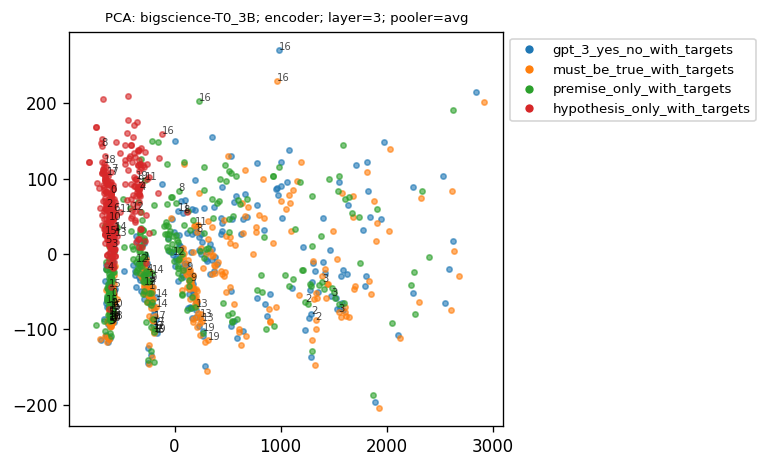



layer= 4


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5750.46it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
(1108, 2)
model:bigscience-T0_3B; module:encoder; layer:4; n_components: 2; variance explained: [0.9786895  0.00877031]
0.9874598


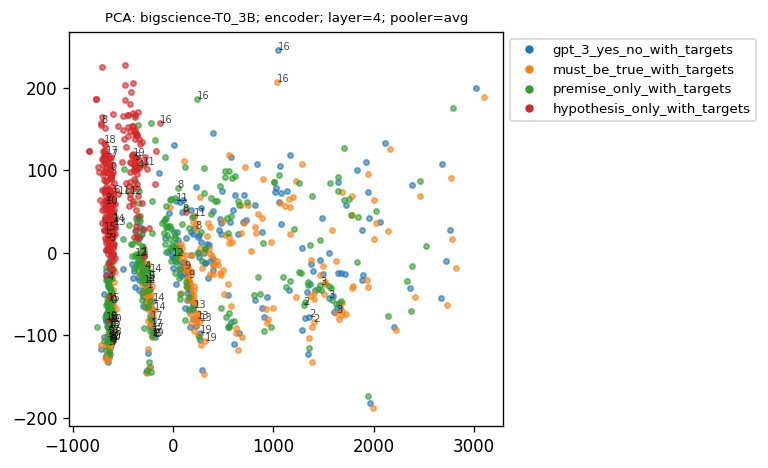



layer= 5


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5393.41it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
(1108, 2)
model:bigscience-T0_3B; module:encoder; layer:5; n_components: 2; variance explained: [0.97815466 0.00891219]
0.98706686


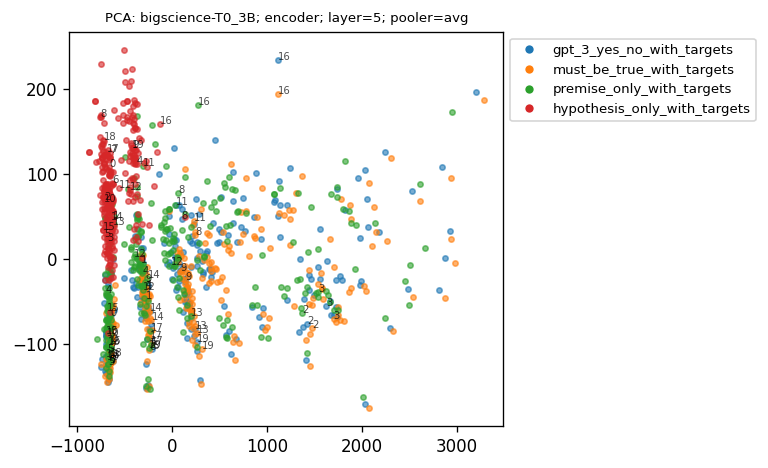



layer= 6


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5467.14it/s]
Exception ignored in: <bound method tqdm.__del__ of <tqdm.std.tqdm object at 0x7f0e325d1eb8>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/tqdm/std.py", line 1147, in __del__
    self.close()
  File "/opt/conda/lib/python3.6/site-packages/tqdm/std.py", line 1276, in close
    if self.last_print_t < self.start_t + self.delay:
AttributeError: 'tqdm' object has no attribute 'last_print_t'


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
(1108, 2)
model:bigscience-T0_3B; module:encoder; layer:6; n_components: 2; variance explained: [9.9873346e-01 6.3142675e-04]
0.9993649


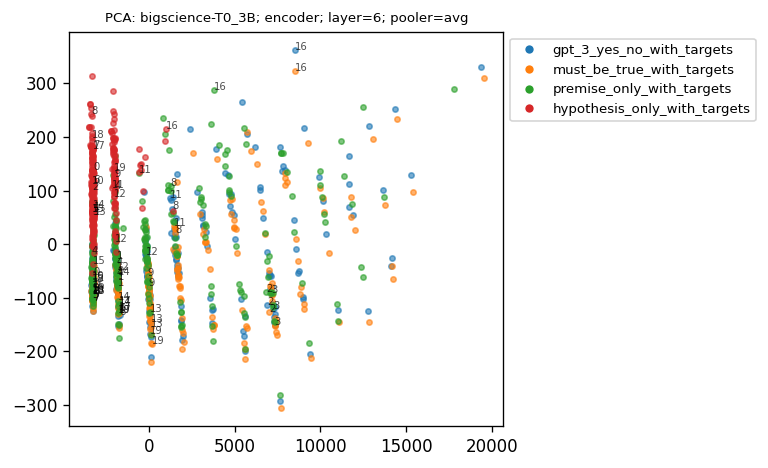



layer= 7


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5388.81it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
(1108, 2)
model:bigscience-T0_3B; module:encoder; layer:7; n_components: 2; variance explained: [9.9855745e-01 6.8728038e-04]
0.99924475


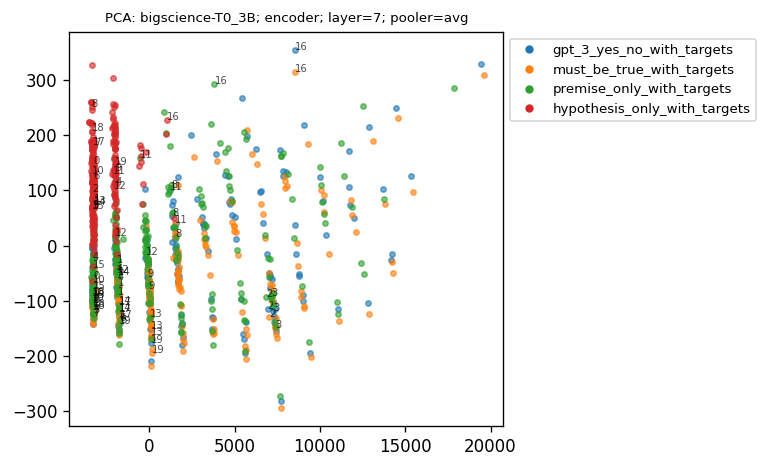



layer= 8


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5964.82it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
(1108, 2)
model:bigscience-T0_3B; module:encoder; layer:8; n_components: 2; variance explained: [9.9835783e-01 7.3816092e-04]
0.999096


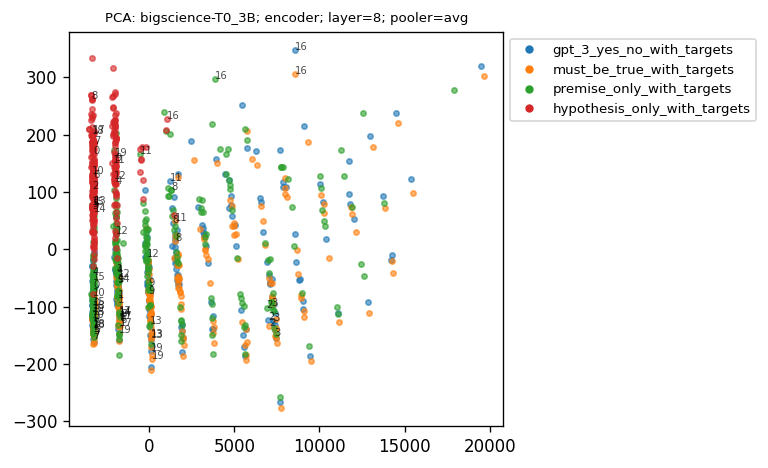



layer= 9


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 4414.12it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
(1108, 2)
model:bigscience-T0_3B; module:encoder; layer:9; n_components: 2; variance explained: [9.9806815e-01 7.8654994e-04]
0.9988547


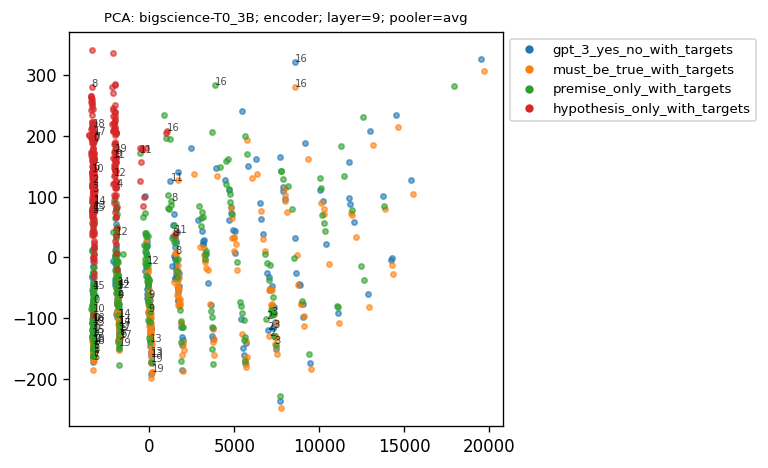



layer= 10


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 4799.77it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
(1108, 2)
model:bigscience-T0_3B; module:encoder; layer:10; n_components: 2; variance explained: [9.9771428e-01 8.1630086e-04]
0.99853057


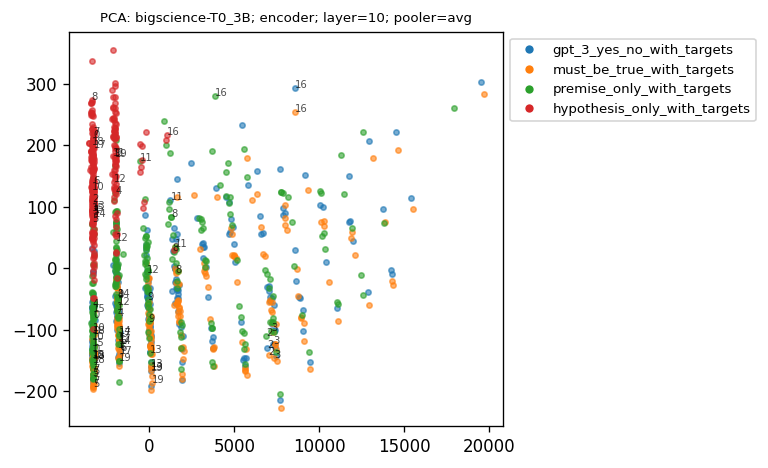



layer= 11


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5556.83it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
(1108, 2)
model:bigscience-T0_3B; module:encoder; layer:11; n_components: 2; variance explained: [9.9720359e-01 8.4174715e-04]
0.9980453


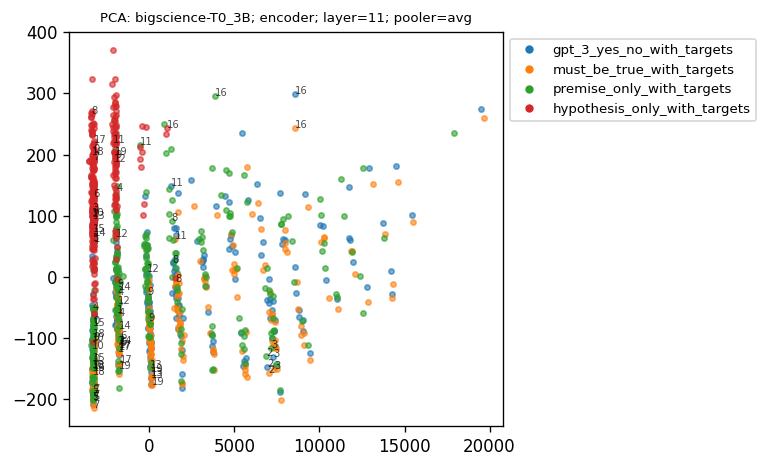



layer= 12


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5690.69it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
(1108, 2)
model:bigscience-T0_3B; module:encoder; layer:12; n_components: 2; variance explained: [0.99617136 0.00118775]
0.9973591


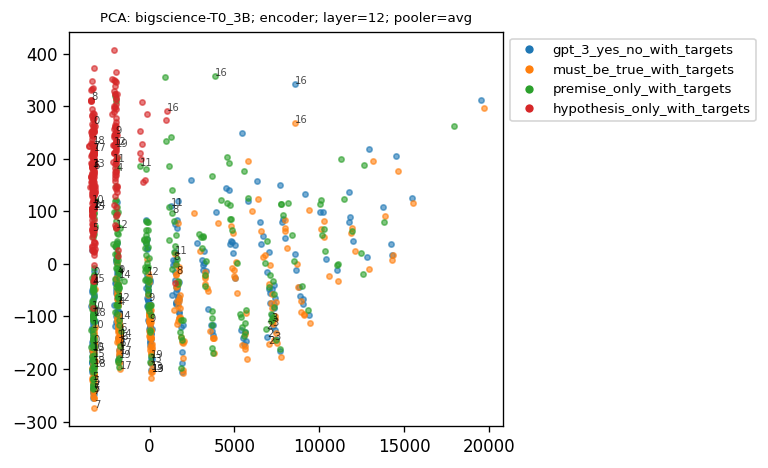



layer= 13


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5586.09it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
(1108, 2)
model:bigscience-T0_3B; module:encoder; layer:13; n_components: 2; variance explained: [0.9944514  0.00159954]
0.99605095


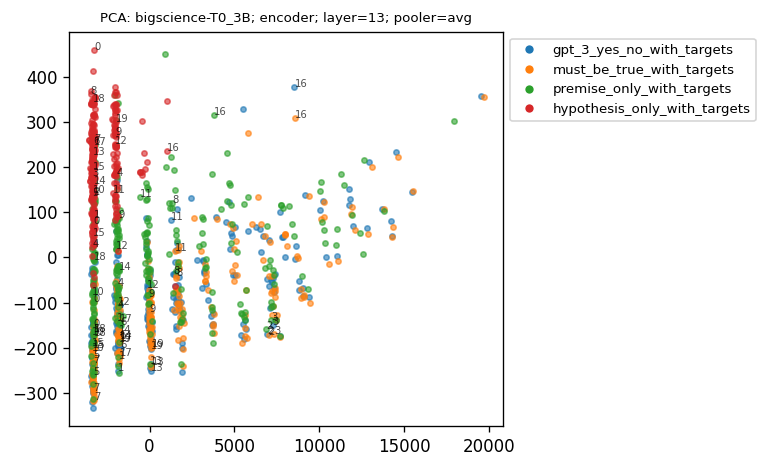



layer= 14


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5565.67it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
(1108, 2)
model:bigscience-T0_3B; module:encoder; layer:14; n_components: 2; variance explained: [0.9926919  0.00200411]
0.99469596


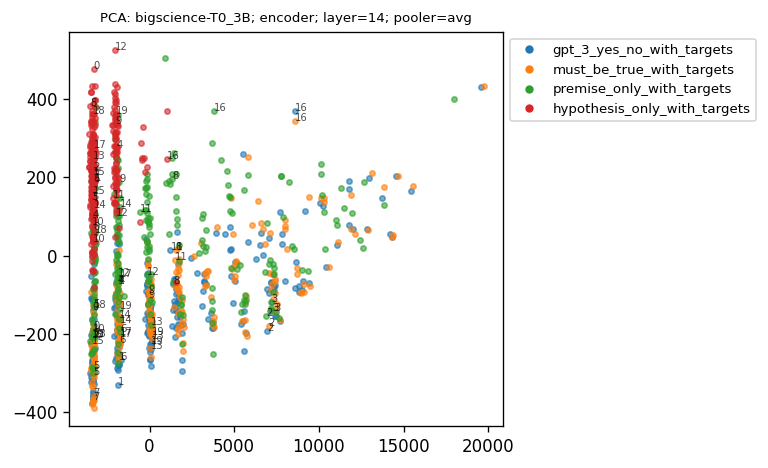



layer= 15


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 4767.02it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
(1108, 2)
model:bigscience-T0_3B; module:encoder; layer:15; n_components: 2; variance explained: [0.9909181 0.0019195]
0.9928376


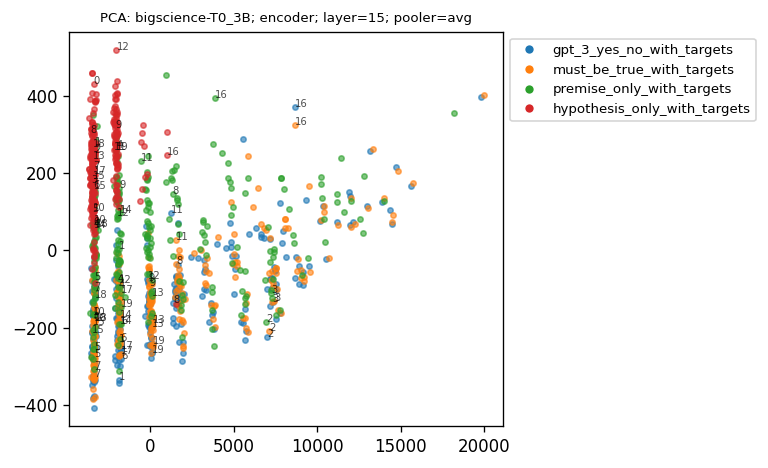



layer= 16


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 6180.66it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
(1108, 2)
model:bigscience-T0_3B; module:encoder; layer:16; n_components: 2; variance explained: [0.9872769  0.00228656]
0.98956347


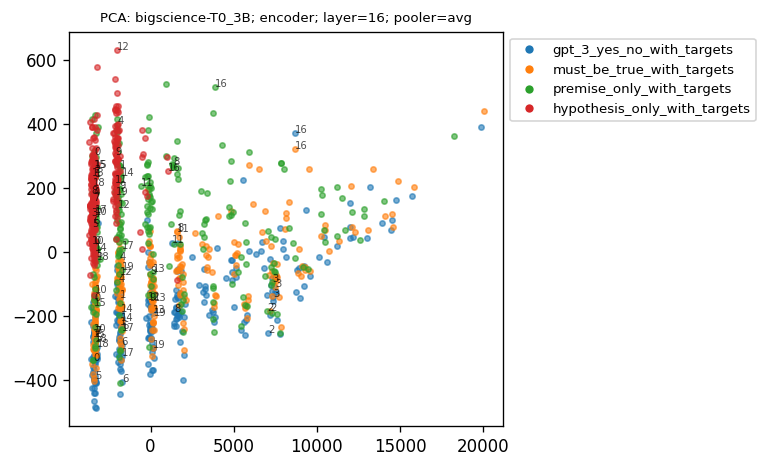



layer= 17


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5896.32it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
(1108, 2)
model:bigscience-T0_3B; module:encoder; layer:17; n_components: 2; variance explained: [0.9812425  0.00320482]
0.9844473


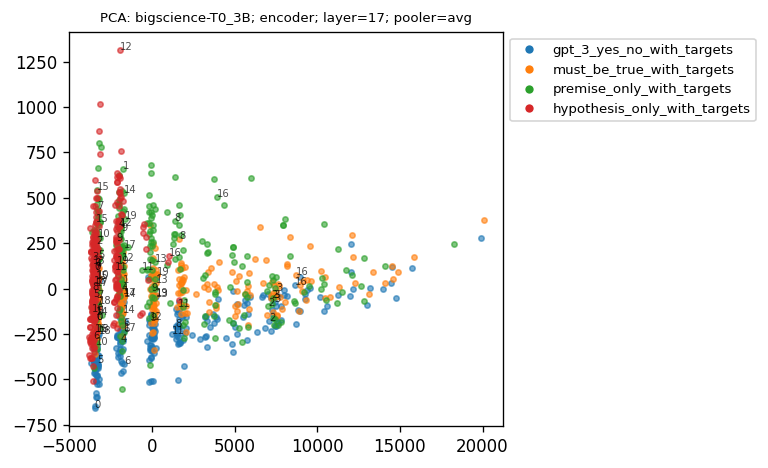



layer= 18


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5604.63it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
(1108, 2)
model:bigscience-T0_3B; module:encoder; layer:18; n_components: 2; variance explained: [0.97119695 0.00672716]
0.9779241


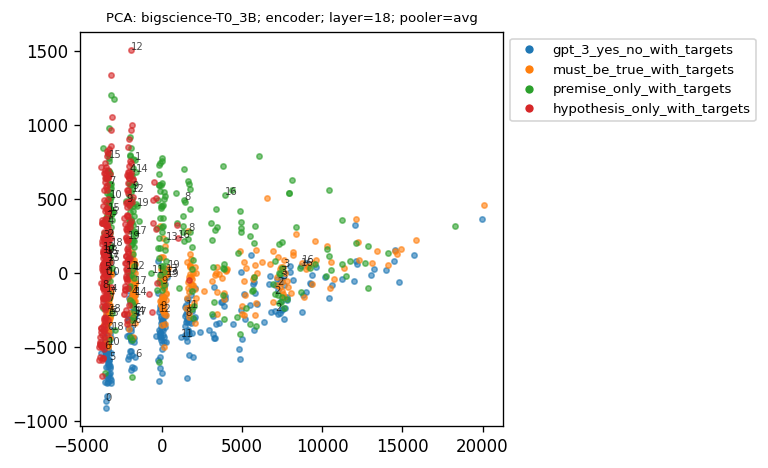



layer= 19


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 4729.37it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
(1108, 2)
model:bigscience-T0_3B; module:encoder; layer:19; n_components: 2; variance explained: [0.96230936 0.00766876]
0.9699781


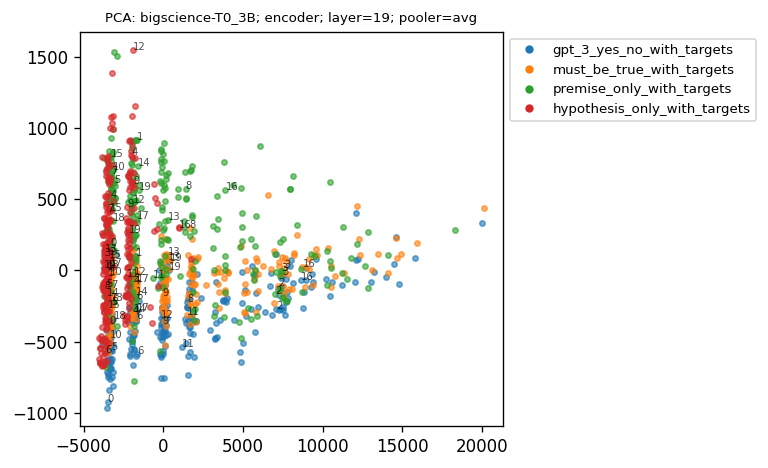



layer= 20


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5342.64it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
(1108, 2)
model:bigscience-T0_3B; module:encoder; layer:20; n_components: 2; variance explained: [0.9478406  0.01126741]
0.959108


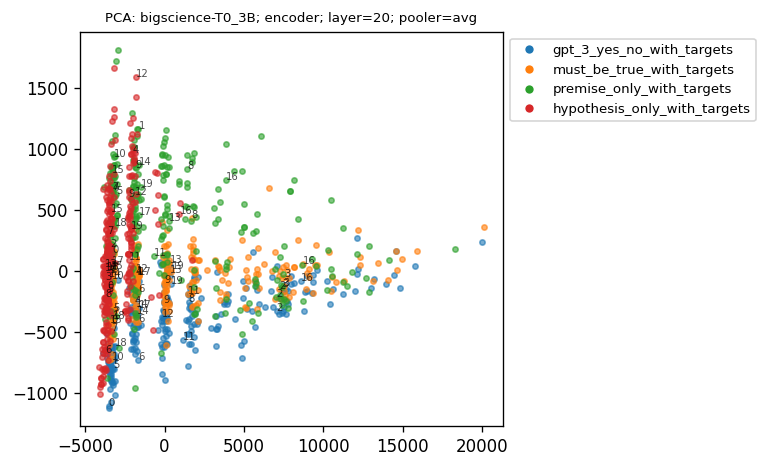



layer= 21


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5539.53it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
(1108, 2)
model:bigscience-T0_3B; module:encoder; layer:21; n_components: 2; variance explained: [0.9329106  0.01364922]
0.94655985


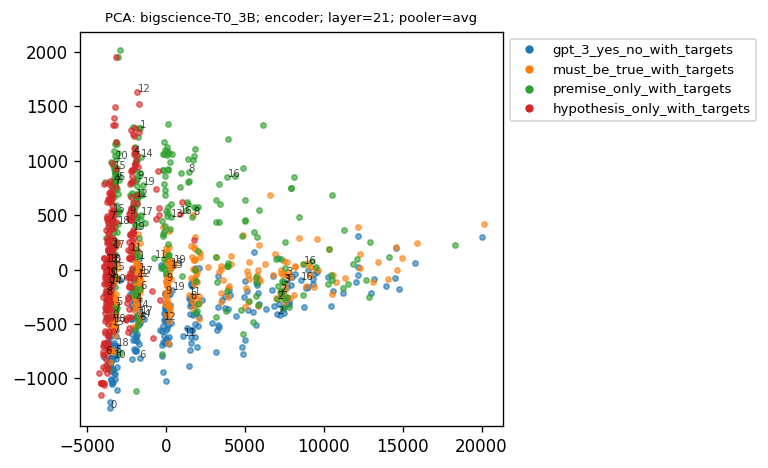



layer= 22


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5763.55it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
(1108, 2)
model:bigscience-T0_3B; module:encoder; layer:22; n_components: 2; variance explained: [0.909466   0.01510908]
0.9245751


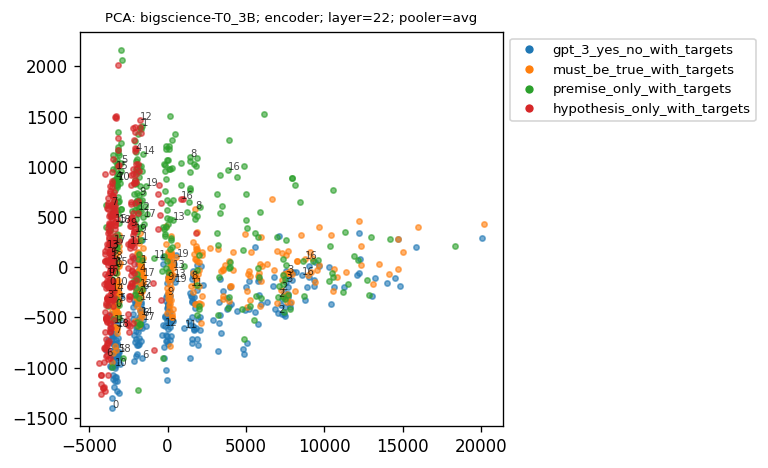



layer= 23


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 5605.60it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
(1108, 2)
model:bigscience-T0_3B; module:encoder; layer:23; n_components: 2; variance explained: [0.8695194  0.02374043]
0.8932598


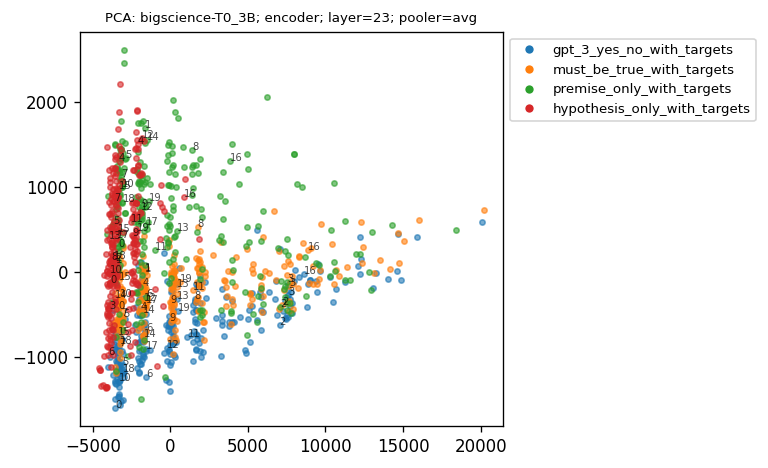



layer= 24


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 6087.84it/s]


(1108, 2048) (1108,)
PCA for prompts: ['gpt_3_yes_no_with_targets', 'must_be_true_with_targets', 'premise_only_with_targets', 'hypothesis_only_with_targets']
(1108, 2)
model:bigscience-T0_3B; module:encoder; layer:24; n_components: 2; variance explained: [0.14011857 0.06567805]
0.20579661


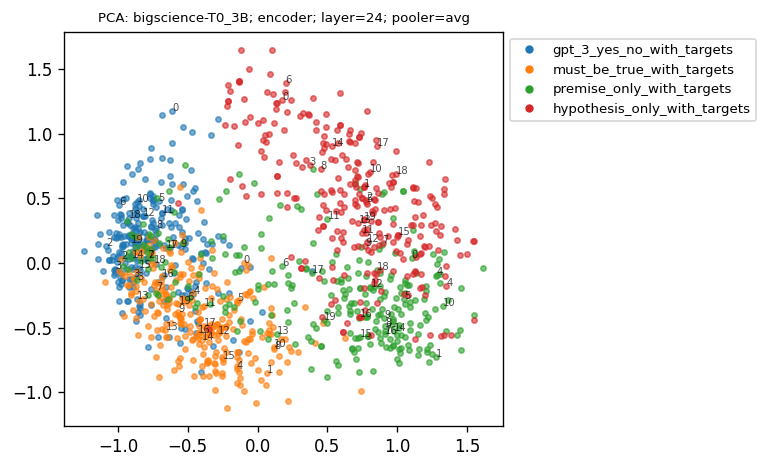

In [29]:
cmap = matplotlib.cm.get_cmap('tab10')
# cmap = matplotlib.cm.get_cmap('tab20')
colors = cmap.colors

layer_dfs = {}

# for layer in range(17, 18):
for layer in range(0, 25):
# for layer in range(24, 25):
    print('layer=', layer)
    file_names, prompt_names = [], []

    tsne_df = {"sid": [], "x": [], "y": [], "template": [], "text": [], "label": [], "prediction": [], "sequence": []}

    for _, row in df.iterrows():
        if row['name'] in use_pattern:
            file_names.append(f"{task}/{model}/{module}/{row['name']}/hidden_represenations_layer{layer}_avg.hdf5",)
            prompt_names.append(row['name'])


    # load hidden representations from hdf5 file
    representations = None
    classes = []
    n_sequences = 0

    for idx, file_name in enumerate(file_names):
        hidden_representations = load_hidden_representations_from_hdf5(os.path.join(log_dir, file_name))
        # print(hidden_representations.shape)
        n_sequences = hidden_representations.shape[0]

        if representations is None:
            representations = hidden_representations
        else:
            representations = np.concatenate((representations, hidden_representations), axis=0)

        classes += n_sequences * [idx] # assign representations to classes
    
    classes = np.asarray(classes)

    X, y = representations, classes
    # shuffle representations and classes
    # X, y = unison_shuffled_copies(representations, classes)
    print(X.shape, y.shape)

    # perform PCA on hidden representations
    print('PCA for prompts:', prompt_names)

    for n_components in range(2, 3):
        n_components = 2
        pca = PCA(n_components=n_components)
        X_pca = pca.fit(X)
        # select components
        pca.components_ = pca.components_[:, :]
        X_pca = X_pca.transform(X)
        print(X_pca.shape)

        # variance explained by each of the principal components
        print(f"model:{model}; module:{module}; layer:{layer}; n_components: {n_components}; variance explained: {pca.explained_variance_ratio_}")
        print(np.sum(pca.explained_variance_ratio_))

        # plot PCA embeddings
        fig, axes = plt.subplots(1, 1, figsize=(6.5,4), dpi=120)
        legend_elements= []

        for idx, file_name in enumerate(file_names):
            x, y = X_pca[n_sequences*idx:n_sequences*(idx + 1), 0], X_pca[n_sequences*idx:n_sequences*(idx + 1), 1]
            axes.scatter(x, y, alpha=0.6, s=[10.0], color=colors[idx])

            # create legend element manually
            legend_elements.append(Line2D([0], [0], marker='o', color='w', label=prompt_names[idx], markerfacecolor=colors[idx], markersize=6))

            # annotate scatter plot with text
            samles_indices = np.random.choice(range(n_sequences), size=20)
            # for i, txt in enumerate(list(range(n_sequences))): # annotate all samples
            # for i, txt in enumerate(samles_indices): # annotate randomly choosen samples
            for i, txt in enumerate(range(20)): # annotate first 10 samples
                axes.annotate(txt, (x[i], y[i]), alpha=0.7, fontsize=6)

            # collect data in dataframe
            for i in range(n_sequences):
                assert len(x) == n_sequences
                tsne_df["sid"].append(i)
                tsne_df["x"].append(x[i])
                tsne_df["y"].append(y[i])
                tsne_df["template"].append(prompt_names[idx])
                tsne_df["text"].append(df_inputs[prompt_names[idx]].iloc[i]["input"])
                tsne_df["label"].append(df_inputs[prompt_names[idx]]['label'].values[i])
                tsne_df["prediction"].append(df_inputs[prompt_names[idx]]['prediction'].values[i])
                tsne_df["sequence"].append(df_outputs[prompt_names[idx]].values[i])
        
        layer_dfs[layer] = pd.DataFrame(tsne_df)
        
        axes.set_title(f"PCA: {model}; {module}; layer={layer}; pooler=avg", fontsize=8)
        axes.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.0, 1.0), fancybox=True, shadow=False, fontsize=8)

        plt.tight_layout()

        plt.show()
        plt.close();
        
    print('\n')


## Create interactive altair plot for a single layer

In [32]:
LAYER = 12

source = layer_dfs[LAYER]
alt.Chart(source, title=f"PCA: {task}; {model}; {module}; layer={LAYER}; pooler=avg").mark_circle(size=60).encode(
    x='x',
    y='y',
    color='template',
    tooltip=['sid', 'text', 'label', 'prediction', 'sequence']
).properties(
    width=500,
    height=400
).interactive()

alt.Chart(...)